# Gender classification with convolutional neural network (CNN)

## Data import

As always, first step is creating dataset. Next cell will read audio files of each folder corresponding to an individual speaker, then extract their featutures and convert them to image ready to be used for convolutional neural network. For simplicity, to make all voices in the same lenghts, only first 5 seconds are selected since raw voices have various length.

In [1]:
import pathlib
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display

df = pd.read_csv('F:/ML/Challenge/voiseed/codes/LibriSpeech/mySPEAKERS.TXT', sep="|")
pathlib.Path(f'F:/ML/Challenge/voiseed/codes/image_data/M').mkdir(parents=True, exist_ok=True) # make folder for Male speakers
pathlib.Path(f'F:/ML/Challenge/voiseed/codes/image_data/F').mkdir(parents=True, exist_ok=True) # make folder for female speakers

speakers_id = os.listdir(f'F:/ML/Challenge/voiseed/codes/LibriSpeech/dev-clean')   #path to dev-clean dataset
for speaker_id in speakers_id:
    speaker_id_folders = os.listdir(f'F:/ML/Challenge/voiseed/codes/LibriSpeech/dev-clean/{speaker_id}')
    for speaker_id_folder in speaker_id_folders:
        audios = os.listdir(f'F:/ML/Challenge/voiseed/codes/LibriSpeech/dev-clean/{speaker_id}/{speaker_id_folder}')
        for audio in audios[:-1]:   # select all elements in audio list except the last one to exlude the txt files inside folders
            y, sr = librosa.load(f'F:/ML/Challenge/voiseed/codes/LibriSpeech/dev-clean/{speaker_id}/{speaker_id_folder}/{audio}', mono=True, duration=5) # only first 5 seconds
            mfcc = librosa.feature.mfcc(y=y, sr=sr) # getting mfcc feature of voice
            
            librosa.display.specshow(librosa.power_to_db(mfcc, ref=np.max), x_axis='time', y_axis='mel', fmin=50,
                                     fmax=280) # Setting min and max frequency to account for human voice frequency
            plt.axis('off') # This is to get rid of the axes and only get the picture 
            a = df.loc[df['ID  '] == int(speaker_id)]  # checking speaker_id with corresponding label
            gender = pd.Series.to_string(a['SEX'])
            plt.savefig(f'F:/ML/Challenge/voiseed/codes/image_data/{str(gender[-2])}/{audio[:-3].replace(".", "")}.png') # save created image to appropriate folder 
            plt.clf()

c:\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


<Figure size 432x288 with 0 Axes>

## Splitting data

After creating all images corresponding to voices, it is time to split them into training and test sets.

In [183]:
# pip install split_folders
import split_folders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.75, .25)`.
split_folders.ratio('F:/ML/Challenge/voiseed/codes/image_data/', output="./data", seed=1337, ratio=(.75, .25))

Generate batches of tensor image data with real-time data augmentation.

In [184]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255)

Defining training and test sets with a fixed target size of 64 x 64.

In [185]:
training_set = train_datagen.flow_from_directory(
        './data/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary',
        shuffle = False)
test_set = test_datagen.flow_from_directory(
        './data/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary',
        shuffle = False )

Found 2026 images belonging to 2 classes.
Found 677 images belonging to 2 classes.


## CNN architecture 

CNN is designed by 3 Conv2D layers, 3 MaxPooling2D layers each followd by some Dropout layers to decrease overfitting. Then, all layers are flattern and followd by some Dense layers.

In [223]:
import keras
keras.backend.clear_session()


from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Input, Add
from keras.models import Sequential


model = Sequential()

#1st hidden layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#2nd hidden layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

#3rd hidden layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

#Flatten
model.add(Flatten())

#Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)         

In [224]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit_generator(training_set,
                    steps_per_epoch=313,
                    validation_data=test_set,
                    validation_steps=63,
                    epochs=50)

Epoch 1/50
313/313 [==============================] - 32s 102ms/step - loss: 0.7062 - accuracy: 0.4558 - val_loss: 0.6951 - val_accuracy: 0.5260
Epoch 2/50
313/313 [==============================] - 33s 106ms/step - loss: 0.6940 - accuracy: 0.5063 - val_loss: 0.6955 - val_accuracy: 0.5333
Epoch 3/50
313/313 [==============================] - 34s 110ms/step - loss: 0.6933 - accuracy: 0.4979 - val_loss: 0.7013 - val_accuracy: 0.5333
Epoch 4/50
313/313 [==============================] - 32s 102ms/step - loss: 0.6962 - accuracy: 0.5201 - val_loss: 0.7573 - val_accuracy: 0.4791
Epoch 5/50
313/313 [==============================] - 33s 106ms/step - loss: 0.5879 - accuracy: 0.6992 - val_loss: 0.1096 - val_accuracy: 0.8264
Epoch 6/50
313/313 [==============================] - 34s 109ms/step - loss: 0.3603 - accuracy: 0.8440 - val_loss: 0.0726 - val_accuracy: 0.8563
Epoch 7/50
313/313 [==============================] - 34s 108ms/step - loss: 0.2624 - accuracy: 0.8885 - val_loss: 0.4787 - val_ac

Accuracy of training and test sets are 0.9948% and 0.95% for the designed architecture which are a little bit less than accuracies of deep learning model. This small difference does not mean that CNN is definitely worse than DNN because there are many hyperparameters here (such as different architecture, optimization method, dropout rate, learning rate, etc) that can be better tuned to reach the same accuracy of DNN or even better than it. Even it is possible to reach higher accuracy by increasing the number of Epochs which I chose 50 here.

## Plotting train and test accuracy

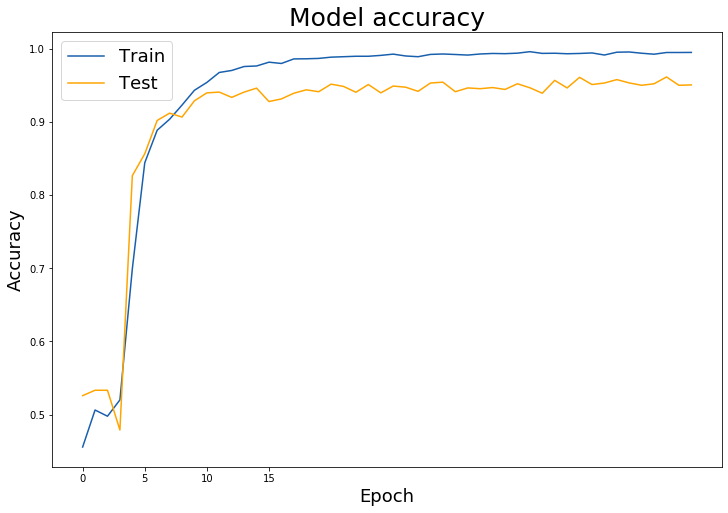

In [233]:
# import PIL
# from sklearn.preprocessing import LabelEncoder
# from PIL import Image

# Check out our train accuracy and validation accuracy over epochs.
import matplotlib as plt
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training and validation accuracy over epochs.
plt.plot(train_accuracy, label='Train', color='#185fad')
plt.plot(val_accuracy, label='Test', color='orange')

# Set title
plt.title('Model accuracy', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(0,20,5), range(0,20,5))

plt.legend(fontsize = 18)
plt.show()

In [226]:
# # Save the entire model as a SavedModel.

import tensorflow as tf
# !mkdir -p saved_model
model.save('saved_model/3layers_model') 

# #Load the entire SavedModel.
# new_model = tf.keras.models.load_model('saved_model/my_model')
# new_model.summary()

## Test your voice!

Does your voice represent a Male or Felame? Let's try!

In [230]:
import IPython.display as ipd
voice_path ='F:/ML/Challenge/voiseed/codes/myvoice.flac'  #path to your voice
ipd.Audio(voice_path) # load a local audio file

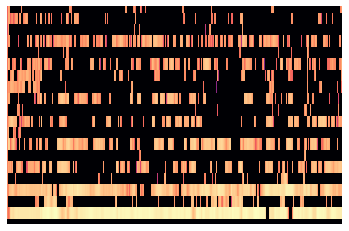

In [231]:
y_test, sr_test = librosa.load(voice_path)
mfccs_test = librosa.feature.mfcc(y=y_test, sr=sr_test)
librosa.display.specshow(librosa.power_to_db(mfccs_test, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280)
plt.axis('off');
plt.savefig("img_test.png", dpi=500, bbox_inches='tight',pad_inches=0)

In [232]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (64, 64, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load('img_test.png')
result = model.predict(image)
if np.round_(result[0][0]) == 1:
    prediction = 'It is voice of a Male'
else:
    prediction = 'I t is voice of a Female'
print(prediction)

It is voice of a Male
